In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import defaultdict, Counter
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,precision_score,classification_report,plot_roc_curve,auc
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split,RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
Rating=pd.read_csv('Reviews.csv')
Rating.head()

,Unnamed: 0,Ratings,Full_review
0,0,5,This is the best laptop in this range.I reciev...
1,1,5,Good product as used of now.... Everything is ...
2,2,5,AWESOME LAPTOP. It supports many high spec gam...
3,3,4,For that price... it's exceptionally good. Pla...
4,4,4,RAM upgrade is must do because the useable RAM...


# EDA

In [3]:
Rating.drop('Unnamed: 0', axis =1, inplace = True)

In [5]:
Rating.shape

(40573, 2)

There are 40573 rows and 2 colums in our dataset

In [7]:
Rating.Ratings.value_counts()

5    22169
4     7219
1     5839
3     3376
2     1970
Name: Ratings, dtype: int64

The dataset looks imbalanced

In [4]:
Rating['length']=Rating.Full_review.str.len()
Rating.head()

,Ratings,Full_review,length
0,5,This is the best laptop in this range.I reciev...,500
1,5,Good product as used of now.... Everything is ...,271
2,5,AWESOME LAPTOP. It supports many high spec gam...,96
3,4,For that price... it's exceptionally good. Pla...,342
4,4,RAM upgrade is must do because the useable RAM...,500


Created another column 'length' based on the length of reviews.

In [9]:
Rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40573 entries, 0 to 40572
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Ratings      40573 non-null  int64 
 1   Full_review  40573 non-null  object
 2   length       40573 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 951.1+ KB


In [10]:
Rating.isnull().sum()

Ratings        0
Full_review    0
length         0
dtype: int64

There are no null values in our dataset

In [5]:
Rating['Full_review']=Rating['Full_review'].str.lower()

Converted texts to lowercase

In [6]:
Rating['Full_review']=Rating['Full_review'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

Rating['Full_review']=Rating['Full_review'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

Rating['Full_review']=Rating['Full_review'].str.replace(r'£|\$', 'dollers')

Rating['Full_review']=Rating['Full_review'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumber')

Rating['Full_review']=Rating['Full_review'].str.replace(r'\d+(\.\d+)?', 'numbr')

Rating['Full_review']=Rating['Full_review'].str.replace(r'[^\w\d\s]', ' ')

Rating['Full_review']=Rating['Full_review'].str.replace(r'\s+', ' ')

Rating['Full_review']=Rating['Full_review'].str.replace(r'^\s+|\s+?$', '')

In [7]:
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english') + ['u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

Rating['Full_review'] = Rating['Full_review'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

Removed the stopwords

In [8]:
Rating['clean_length'] = Rating.Full_review.str.len()

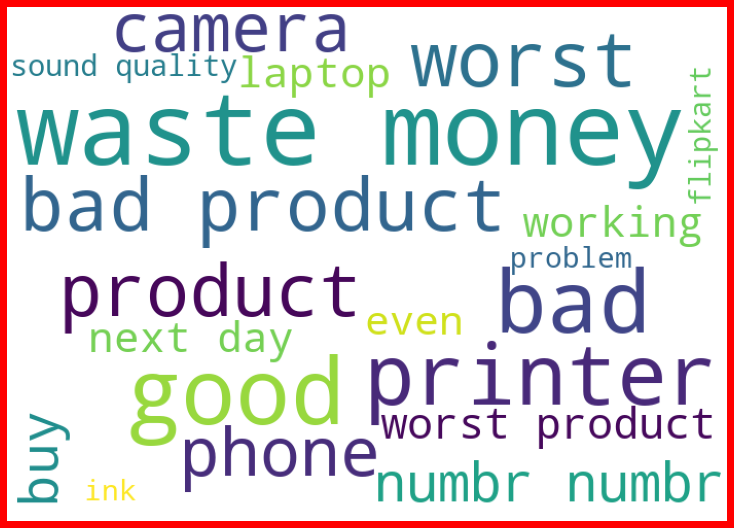

In [9]:
from wordcloud import WordCloud

Rating1=Rating['Full_review'][Rating['Ratings']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating1))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

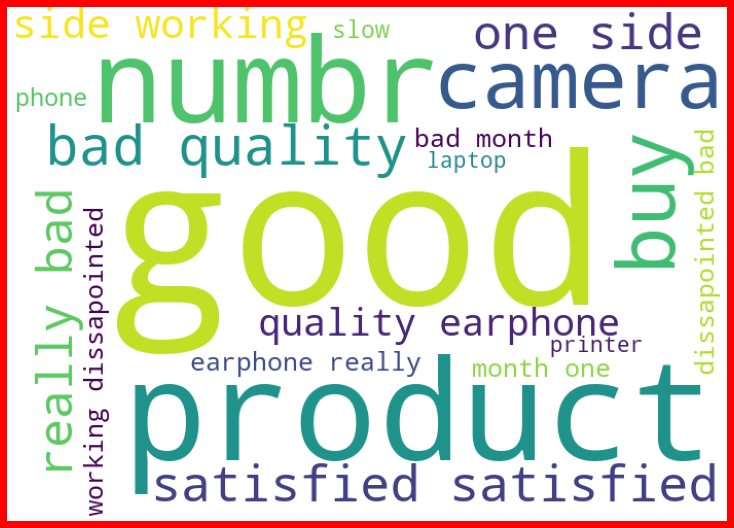

In [10]:
Rating2=Rating['Full_review'][Rating['Ratings']==2]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating2))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

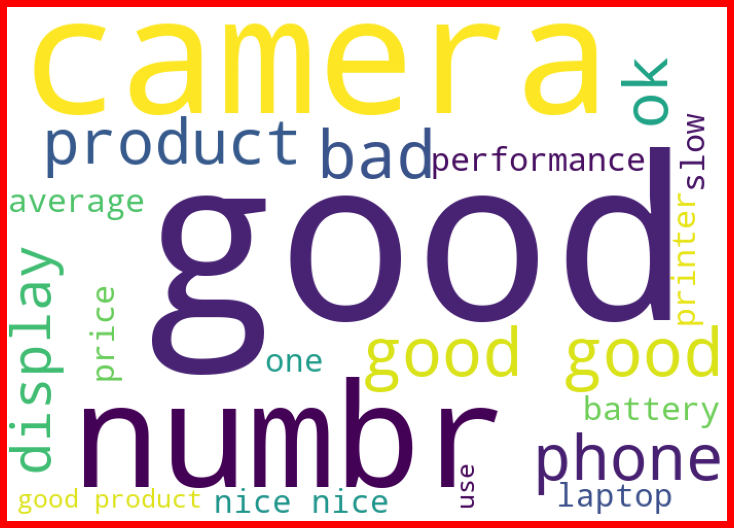

In [11]:
Rating3=Rating['Full_review'][Rating['Ratings']==3]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating3))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

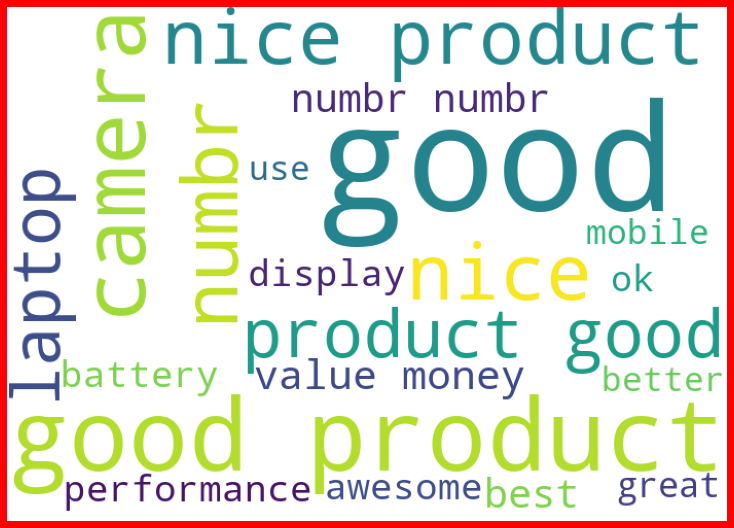

In [12]:
Rating4=Rating['Full_review'][Rating['Ratings']==4]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating4))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

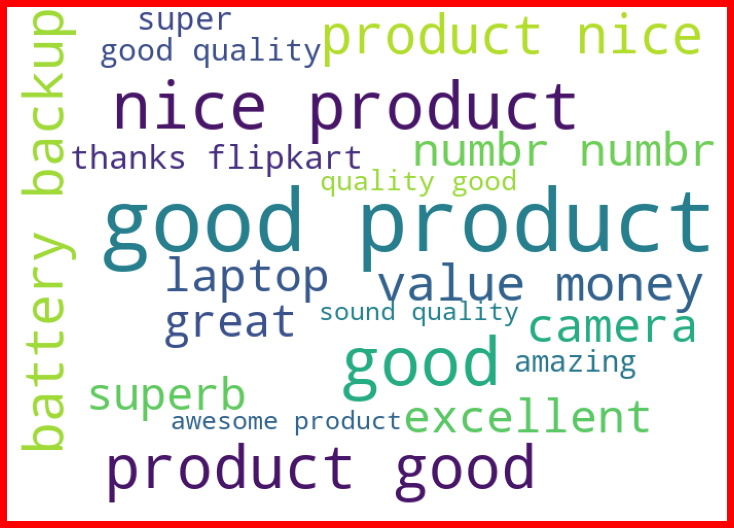

In [13]:
Rating5=Rating['Full_review'][Rating['Ratings']==5]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating5))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vec=TfidfVectorizer()
feature1=tf_vec.fit_transform(Rating['Full_review'])

# Model Building

In [15]:
x=feature1
y=Rating['Ratings']

In [16]:
from imblearn.over_sampling import SMOTE
SM=SMOTE()
x,y=SM.fit_resample(x,y)

y.value_counts()

5    22169
4    22169
3    22169
2    22169
1    22169
Name: Ratings, dtype: int64

The dataset is now balanced

### Finding the best random state

In [26]:
maxAccu=0
maxRs=0
for i in range(1,200):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=i)
    mod=DecisionTreeClassifier()
    mod.fit(x_train,y_train)
    pred=mod.predict(x_test)
    acc=accuracy_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRs=i
print("Best accuracy is:",maxAccu,"on Random State",maxRs)

Best accuracy is: 0.6894486143187067 on Random State 105


In [17]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=105)

In [26]:
DTC=DecisionTreeClassifier()
DTC.fit(x_train,y_train)
pred=DTC.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.84      0.76      0.80      5534
           2       0.79      0.84      0.81      5580
           3       0.65      0.61      0.63      5490
           4       0.55      0.58      0.56      5539
           5       0.63      0.64      0.63      5569

    accuracy                           0.69     27712
   macro avg       0.69      0.69      0.69     27712
weighted avg       0.69      0.69      0.69     27712



In [22]:
RFC=RandomForestClassifier()
RFC.fit(x_train,y_train)
pred=RFC.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.86      0.88      0.87      5534
           2       0.92      0.87      0.89      5580
           3       0.77      0.73      0.75      5490
           4       0.63      0.70      0.66      5539
           5       0.71      0.69      0.70      5569

    accuracy                           0.77     27712
   macro avg       0.78      0.77      0.78     27712
weighted avg       0.78      0.77      0.78     27712



In [28]:
SV=SVC()
SV.fit(x_train,y_train)
pred=SV.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.90      0.80      0.84      5534
           2       0.82      0.87      0.85      5580
           3       0.74      0.67      0.70      5490
           4       0.63      0.62      0.62      5539
           5       0.67      0.77      0.71      5569

    accuracy                           0.75     27712
   macro avg       0.75      0.75      0.75     27712
weighted avg       0.75      0.75      0.75     27712



In [29]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
pred=lr.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.72      0.70      0.71      5534
           2       0.64      0.69      0.67      5580
           3       0.49      0.62      0.55      5490
           4       0.54      0.44      0.48      5539
           5       0.63      0.55      0.59      5569

    accuracy                           0.60     27712
   macro avg       0.60      0.60      0.60     27712
weighted avg       0.60      0.60      0.60     27712



In [18]:
ada=AdaBoostClassifier()
ada.fit(x_train,y_train)
pred=ada.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.60      0.61      0.60      5534
           2       0.57      0.41      0.48      5580
           3       0.40      0.31      0.35      5490
           4       0.39      0.44      0.42      5539
           5       0.43      0.58      0.49      5569

    accuracy                           0.47     27712
   macro avg       0.48      0.47      0.47     27712
weighted avg       0.48      0.47      0.47     27712



In [19]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
pred=knn.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.66      0.83      0.74      5534
           2       0.81      0.87      0.84      5580
           3       0.64      0.73      0.69      5490
           4       0.65      0.50      0.57      5539
           5       0.59      0.44      0.50      5569

    accuracy                           0.68     27712
   macro avg       0.67      0.68      0.67     27712
weighted avg       0.67      0.68      0.67     27712



In [20]:
gbc=GradientBoostingClassifier()
gbc.fit(x_train,y_train)
pred=gbc.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.59      0.73      0.65      5534
           2       0.65      0.52      0.58      5580
           3       0.48      0.42      0.44      5490
           4       0.43      0.54      0.48      5539
           5       0.62      0.53      0.57      5569

    accuracy                           0.55     27712
   macro avg       0.56      0.55      0.55     27712
weighted avg       0.56      0.55      0.55     27712



In [25]:
mnb=MultinomialNB()
mnb.fit(x_train,y_train)
pred=mnb.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.74      0.67      0.70      5534
           2       0.64      0.67      0.65      5580
           3       0.53      0.46      0.49      5490
           4       0.47      0.54      0.50      5539
           5       0.57      0.58      0.58      5569

    accuracy                           0.58     27712
   macro avg       0.59      0.58      0.59     27712
weighted avg       0.59      0.58      0.59     27712



### Cross validation

In [30]:
print(cross_val_score(DTC,x,y,cv=5).mean())
print(cross_val_score(RFC,x,y,cv=5).mean())
print(cross_val_score(SV,x,y,cv=5).mean())
print(cross_val_score(lr,x,y,cv=5).mean())
print(cross_val_score(ada,x,y,cv=5).mean())
print(cross_val_score(knn,x,y,cv=5).mean())
print(cross_val_score(gbc,x,y,cv=5).mean())
print(cross_val_score(mnb,x,y,cv=5).mean())

0.6616987685506789
0.7506337678740584
0.7063557219540799
0.5631016284000181
0.44247372457034595
0.6521809734313682
0.516604267219992
0.553565790067211


By the scores of accuracy and cross validation, we find random forest as our best model

# Hyperparameter Tuning

In [18]:
parameters={'n_estimators':[200,700],
           'max_features':['auto','sqrt','log2'],
           'criterion':['gini', 'entropy'],
           'max_depth':[50,80,100],
           'min_samples_leaf': [3, 4, 5]}
RCV=RandomizedSearchCV(RandomForestClassifier(),param_distributions=parameters,cv=5)
RCV.fit(x_train,y_train)
RCV.best_params_

{'n_estimators': 200,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'gini'}

In [19]:
Final_model=RandomForestClassifier(n_estimators=200,max_features='sqrt',criterion='gini',max_depth=100,min_samples_leaf=3)
Final_model.fit(x_train,y_train)
pred=Final_model.predict(x_test)
acc=accuracy_score(y_test,pred)
print('Accuracy:',acc*100)

Accuracy: 65.01876443418014


# Saving model

In [23]:
import joblib
joblib.dump(RFC,'Ratings_prediction.csv')

['Ratings_prediction.csv']